In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_dir = 'Face-Mask-Dataset/Train'
val_dir = 'Face-Mask-Dataset/Validation'
test_dir= 'Face-Mask-Dataset/Test'

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
      
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

# Flow test images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 11315 images belonging to 2 classes.
Found 994 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
H = model.fit(
	train_generator,
  steps_per_epoch=len(train_generator)/BS,
	validation_data=validation_generator,
  validation_steps = len(validation_generator)/BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
17/17 [==============================] - 95s 5s/step - loss: 0.7608 - accuracy: 0.5861 - val_loss: 0.5297 - val_accuracy: 0.8250
Epoch 2/20
17/17 [==============================] - 97s 6s/step - loss: 0.6033 - accuracy: 0.7139 - val_loss: 0.4641 - val_accuracy: 0.8250
Epoch 3/20
17/17 [==============================] - 96s 6s/step - loss: 0.4897 - accuracy: 0.8250 - val_loss: 0.3430 - val_accuracy: 0.9750
Epoch 4/20
17/17 [==============================] - 90s 5s/step - loss: 0.4113 - accuracy: 0.8472 - val_loss: 0.2791 - val_accuracy: 0.9750
Epoch 5/20
17/17 [==============================] - 86s 5s/step - loss: 0.3670 - accuracy: 0.8722 - val_loss: 0.3256 - val_accuracy: 0.9000
Epoch 6/20
17/17 [==============================] - 80s 5s/step - loss: 0.3170 - accuracy: 0.8889 - val_loss: 0.2328 - val_accuracy: 0.9750
Epoch 7/20
17/17 [==============================] - 78s 4s/step - loss: 0.2907 - accuracy: 0.9056 - val_loss: 0.2564 - val_accuracy: 0.9

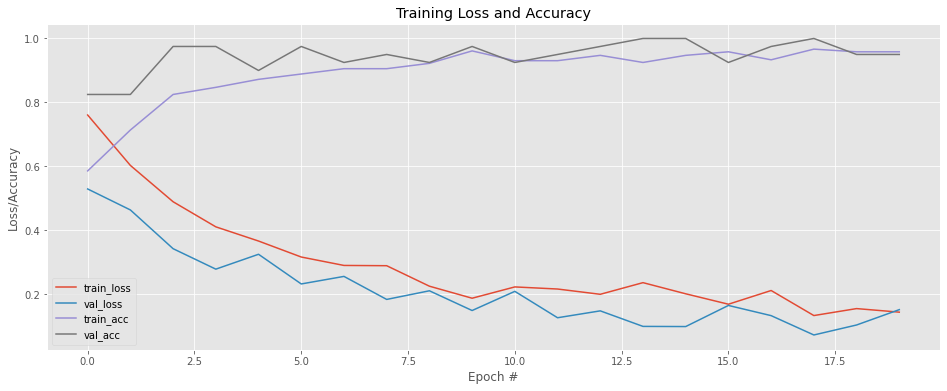

In [ ]:
N = EPOCHS
plt.style.use("seaborn")
plt.figure(figsize=(16,6))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [ ]:
model.evaluate(test_generator)

50/50 [==============================] - 239s 5s/step - loss: 0.0965 - accuracy: 0.9798


[0.09646929055452347, 0.9798387289047241]

In [ ]:
model.save('mask_recog.h5')